## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [ ]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [ ]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  val_last_window_size = val_data[-window_size:]
  test_data_extended = np.concatenate((val_last_window_size, test_data), axis=0)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data_extended, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [ ]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-17 00:32:04,319] A new study created in memory with name: no-name-041937b7-ecee-4cb7-90d1-3a29ca4e5ffe


8/8 [==============================] - 1s 5ms/step


[I 2023-06-17 00:32:19,073] Trial 0 finished with value: 11.337009240388776 and parameters: {'window_size': 13, 'tcn_filters': 95, 'tcn_kernel_size': 3, 'dropout_rate': 0.21219859046190642, 'attention_dim': 26}. Best is trial 0 with value: 11.337009240388776.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:32:29,363] Trial 1 finished with value: 9.090234909862188 and parameters: {'window_size': 29, 'tcn_filters': 37, 'tcn_kernel_size': 2, 'dropout_rate': 0.1491422893776663, 'attention_dim': 17}. Best is trial 1 with value: 9.090234909862188.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:32:34,409] Trial 2 finished with value: 7.919432337901014 and parameters: {'window_size': 13, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.41227548680494175, 'attention_dim': 13}. Best is trial 2 with value: 7.919432337901014.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:32:41,243] Trial 3 finished with value: 9.446722286346475 and parameters: {'window_size': 25, 'tcn_filters': 77, 'tcn_kernel_size': 3, 'dropout_rate': 0.39881607052200396, 'attention_dim': 18}. Best is trial 2 with value: 7.919432337901014.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:32:48,199] Trial 4 finished with value: 6.584973383806969 and parameters: {'window_size': 15, 'tcn_filters': 50, 'tcn_kernel_size': 4, 'dropout_rate': 0.25555414770330265, 'attention_dim': 19}. Best is trial 4 with value: 6.584973383806969.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:32:53,390] Trial 5 finished with value: 34.51234963804393 and parameters: {'window_size': 36, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.22499195196391503, 'attention_dim': 20}. Best is trial 4 with value: 6.584973383806969.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:33:04,330] Trial 6 finished with value: 6.739594091918926 and parameters: {'window_size': 21, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.4880130578410028, 'attention_dim': 29}. Best is trial 4 with value: 6.584973383806969.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:33:19,216] Trial 7 finished with value: 30.579183244944822 and parameters: {'window_size': 41, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.11214196128350942, 'attention_dim': 14}. Best is trial 4 with value: 6.584973383806969.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:33:26,045] Trial 8 finished with value: 9.057394392549732 and parameters: {'window_size': 81, 'tcn_filters': 66, 'tcn_kernel_size': 5, 'dropout_rate': 0.35936470719128055, 'attention_dim': 24}. Best is trial 4 with value: 6.584973383806969.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:33:32,888] Trial 9 finished with value: 12.790431701845172 and parameters: {'window_size': 81, 'tcn_filters': 44, 'tcn_kernel_size': 4, 'dropout_rate': 0.15817790341728255, 'attention_dim': 9}. Best is trial 4 with value: 6.584973383806969.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:33:44,892] Trial 10 finished with value: 6.528511100495602 and parameters: {'window_size': 59, 'tcn_filters': 57, 'tcn_kernel_size': 4, 'dropout_rate': 0.28877462141596927, 'attention_dim': 31}. Best is trial 10 with value: 6.528511100495602.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:34:07,099] Trial 11 finished with value: 8.015378369887475 and parameters: {'window_size': 61, 'tcn_filters': 57, 'tcn_kernel_size': 4, 'dropout_rate': 0.27779604347499165, 'attention_dim': 31}. Best is trial 10 with value: 6.528511100495602.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:34:16,835] Trial 12 finished with value: 9.79520905306777 and parameters: {'window_size': 59, 'tcn_filters': 53, 'tcn_kernel_size': 4, 'dropout_rate': 0.30983765296628735, 'attention_dim': 23}. Best is trial 10 with value: 6.528511100495602.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:34:29,196] Trial 13 finished with value: 5.490512787372311 and parameters: {'window_size': 47, 'tcn_filters': 67, 'tcn_kernel_size': 4, 'dropout_rate': 0.2803848049610493, 'attention_dim': 32}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:34:33,971] Trial 14 finished with value: 17.812346220971015 and parameters: {'window_size': 49, 'tcn_filters': 71, 'tcn_kernel_size': 5, 'dropout_rate': 0.31205700804010583, 'attention_dim': 32}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:34:38,828] Trial 15 finished with value: 14.05574011900442 and parameters: {'window_size': 100, 'tcn_filters': 32, 'tcn_kernel_size': 3, 'dropout_rate': 0.3312857474094626, 'attention_dim': 28}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:34:51,502] Trial 16 finished with value: 10.993299583922886 and parameters: {'window_size': 69, 'tcn_filters': 62, 'tcn_kernel_size': 4, 'dropout_rate': 0.2532208289893411, 'attention_dim': 32}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:35:02,111] Trial 17 finished with value: 6.805689349696216 and parameters: {'window_size': 48, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.21351633011773757, 'attention_dim': 28}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-17 00:35:24,472] Trial 18 finished with value: 7.8433010142714235 and parameters: {'window_size': 69, 'tcn_filters': 91, 'tcn_kernel_size': 5, 'dropout_rate': 0.2845045846181363, 'attention_dim': 23}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:35:33,066] Trial 19 finished with value: 8.003049235570119 and parameters: {'window_size': 42, 'tcn_filters': 104, 'tcn_kernel_size': 4, 'dropout_rate': 0.35792769513260714, 'attention_dim': 25}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:35:39,987] Trial 20 finished with value: 30.12853901388633 and parameters: {'window_size': 78, 'tcn_filters': 69, 'tcn_kernel_size': 3, 'dropout_rate': 0.24587099322151088, 'attention_dim': 30}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:35:47,603] Trial 21 finished with value: 12.527707431034495 and parameters: {'window_size': 53, 'tcn_filters': 48, 'tcn_kernel_size': 4, 'dropout_rate': 0.2579713160473624, 'attention_dim': 21}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:35:59,787] Trial 22 finished with value: 6.380502699582357 and parameters: {'window_size': 34, 'tcn_filters': 42, 'tcn_kernel_size': 4, 'dropout_rate': 0.28993992732041923, 'attention_dim': 17}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:36:04,198] Trial 23 finished with value: 8.851524862846766 and parameters: {'window_size': 35, 'tcn_filters': 39, 'tcn_kernel_size': 4, 'dropout_rate': 0.2871096046885401, 'attention_dim': 16}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:36:16,859] Trial 24 finished with value: 6.664689311624825 and parameters: {'window_size': 66, 'tcn_filters': 57, 'tcn_kernel_size': 5, 'dropout_rate': 0.3256350473102126, 'attention_dim': 9}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:36:26,639] Trial 25 finished with value: 31.94044484593806 and parameters: {'window_size': 42, 'tcn_filters': 44, 'tcn_kernel_size': 4, 'dropout_rate': 0.28544301555799795, 'attention_dim': 27}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:36:33,612] Trial 26 finished with value: 6.647759518510375 and parameters: {'window_size': 31, 'tcn_filters': 61, 'tcn_kernel_size': 3, 'dropout_rate': 0.19303900873116156, 'attention_dim': 12}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:36:38,741] Trial 27 finished with value: 16.43514019073071 and parameters: {'window_size': 54, 'tcn_filters': 72, 'tcn_kernel_size': 4, 'dropout_rate': 0.2343013038433071, 'attention_dim': 15}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:36:52,511] Trial 28 finished with value: 14.163567287233535 and parameters: {'window_size': 45, 'tcn_filters': 82, 'tcn_kernel_size': 5, 'dropout_rate': 0.2667219488412793, 'attention_dim': 22}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:36:57,359] Trial 29 finished with value: 6.680719687958087 and parameters: {'window_size': 90, 'tcn_filters': 32, 'tcn_kernel_size': 4, 'dropout_rate': 0.1972509592933242, 'attention_dim': 26}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:37:05,400] Trial 30 finished with value: 13.444351315678386 and parameters: {'window_size': 20, 'tcn_filters': 55, 'tcn_kernel_size': 3, 'dropout_rate': 0.30636172001483697, 'attention_dim': 30}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:37:10,842] Trial 31 finished with value: 5.696617714510948 and parameters: {'window_size': 12, 'tcn_filters': 50, 'tcn_kernel_size': 4, 'dropout_rate': 0.24118840864198254, 'attention_dim': 19}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:37:15,327] Trial 32 finished with value: 8.107269482555878 and parameters: {'window_size': 11, 'tcn_filters': 43, 'tcn_kernel_size': 4, 'dropout_rate': 0.23325663806894387, 'attention_dim': 18}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:37:22,994] Trial 33 finished with value: 11.935600140394044 and parameters: {'window_size': 34, 'tcn_filters': 63, 'tcn_kernel_size': 4, 'dropout_rate': 0.26779128511294314, 'attention_dim': 17}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:37:35,121] Trial 34 finished with value: 5.967606641923634 and parameters: {'window_size': 26, 'tcn_filters': 38, 'tcn_kernel_size': 4, 'dropout_rate': 0.19283662457808634, 'attention_dim': 21}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:37:43,031] Trial 35 finished with value: 7.487387992077627 and parameters: {'window_size': 25, 'tcn_filters': 38, 'tcn_kernel_size': 4, 'dropout_rate': 0.19405199295762365, 'attention_dim': 12}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:37:50,604] Trial 36 finished with value: 6.860821852470377 and parameters: {'window_size': 18, 'tcn_filters': 50, 'tcn_kernel_size': 5, 'dropout_rate': 0.16718079816405385, 'attention_dim': 20}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:37:58,238] Trial 37 finished with value: 6.545729060422657 and parameters: {'window_size': 26, 'tcn_filters': 37, 'tcn_kernel_size': 3, 'dropout_rate': 0.20462968470787063, 'attention_dim': 19}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:38:02,972] Trial 38 finished with value: 7.519501957611533 and parameters: {'window_size': 16, 'tcn_filters': 48, 'tcn_kernel_size': 4, 'dropout_rate': 0.22601487134895662, 'attention_dim': 16}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:38:09,337] Trial 39 finished with value: 11.239484060503509 and parameters: {'window_size': 28, 'tcn_filters': 41, 'tcn_kernel_size': 5, 'dropout_rate': 0.17583401776189975, 'attention_dim': 21}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:38:15,064] Trial 40 finished with value: 9.159477672818584 and parameters: {'window_size': 10, 'tcn_filters': 46, 'tcn_kernel_size': 2, 'dropout_rate': 0.133962441844631, 'attention_dim': 14}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:38:27,248] Trial 41 finished with value: 6.676600982796323 and parameters: {'window_size': 37, 'tcn_filters': 76, 'tcn_kernel_size': 4, 'dropout_rate': 0.24577840367879142, 'attention_dim': 18}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:38:39,443] Trial 42 finished with value: 8.019465687206372 and parameters: {'window_size': 32, 'tcn_filters': 54, 'tcn_kernel_size': 4, 'dropout_rate': 0.21354866930705402, 'attention_dim': 30}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:38:46,721] Trial 43 finished with value: 6.57562892557801 and parameters: {'window_size': 23, 'tcn_filters': 60, 'tcn_kernel_size': 4, 'dropout_rate': 0.2963777096279996, 'attention_dim': 19}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:38:52,615] Trial 44 finished with value: 12.041326039300486 and parameters: {'window_size': 58, 'tcn_filters': 36, 'tcn_kernel_size': 4, 'dropout_rate': 0.2715489806255414, 'attention_dim': 25}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:39:06,002] Trial 45 finished with value: 10.117948884280745 and parameters: {'window_size': 39, 'tcn_filters': 66, 'tcn_kernel_size': 4, 'dropout_rate': 0.23824302009841644, 'attention_dim': 32}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:39:10,762] Trial 46 finished with value: 25.643494983237776 and parameters: {'window_size': 15, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.2564008006878017, 'attention_dim': 11}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:39:17,632] Trial 47 finished with value: 6.271300393176895 and parameters: {'window_size': 48, 'tcn_filters': 50, 'tcn_kernel_size': 3, 'dropout_rate': 0.22047772479659544, 'attention_dim': 28}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:39:24,521] Trial 48 finished with value: 22.133184398649174 and parameters: {'window_size': 48, 'tcn_filters': 52, 'tcn_kernel_size': 3, 'dropout_rate': 0.1759512584949871, 'attention_dim': 28}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:39:30,303] Trial 49 finished with value: 13.721937257601244 and parameters: {'window_size': 29, 'tcn_filters': 33, 'tcn_kernel_size': 3, 'dropout_rate': 0.21649417323738532, 'attention_dim': 17}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:39:34,249] Trial 50 finished with value: 70.13757261548433 and parameters: {'window_size': 51, 'tcn_filters': 43, 'tcn_kernel_size': 3, 'dropout_rate': 0.15033556731737802, 'attention_dim': 21}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:39:41,774] Trial 51 finished with value: 11.931953537978758 and parameters: {'window_size': 57, 'tcn_filters': 57, 'tcn_kernel_size': 2, 'dropout_rate': 0.2728770399894986, 'attention_dim': 31}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:39:53,106] Trial 52 finished with value: 7.850795362165948 and parameters: {'window_size': 63, 'tcn_filters': 49, 'tcn_kernel_size': 4, 'dropout_rate': 0.2978368293308734, 'attention_dim': 29}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:40:05,846] Trial 53 finished with value: 22.301616879058017 and parameters: {'window_size': 45, 'tcn_filters': 67, 'tcn_kernel_size': 4, 'dropout_rate': 0.2242899209007142, 'attention_dim': 31}. Best is trial 13 with value: 5.490512787372311.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:40:18,116] Trial 54 finished with value: 5.4591769286618765 and parameters: {'window_size': 45, 'tcn_filters': 46, 'tcn_kernel_size': 4, 'dropout_rate': 0.32243276131544185, 'attention_dim': 29}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:40:28,498] Trial 55 finished with value: 12.514895881133945 and parameters: {'window_size': 39, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.3417451906416491, 'attention_dim': 23}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:40:35,439] Trial 56 finished with value: 12.660040405235641 and parameters: {'window_size': 44, 'tcn_filters': 40, 'tcn_kernel_size': 3, 'dropout_rate': 0.31536175291722573, 'attention_dim': 29}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:40:47,405] Trial 57 finished with value: 8.696460216867996 and parameters: {'window_size': 37, 'tcn_filters': 46, 'tcn_kernel_size': 4, 'dropout_rate': 0.24769420001896056, 'attention_dim': 27}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:40:53,381] Trial 58 finished with value: 31.436744369115516 and parameters: {'window_size': 47, 'tcn_filters': 35, 'tcn_kernel_size': 4, 'dropout_rate': 0.28463407954057834, 'attention_dim': 24}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:40:58,825] Trial 59 finished with value: 13.928164602119278 and parameters: {'window_size': 52, 'tcn_filters': 53, 'tcn_kernel_size': 3, 'dropout_rate': 0.3797252043713121, 'attention_dim': 27}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:41:06,285] Trial 60 finished with value: 7.392124556718521 and parameters: {'window_size': 21, 'tcn_filters': 74, 'tcn_kernel_size': 5, 'dropout_rate': 0.3198747138226975, 'attention_dim': 20}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:41:18,280] Trial 61 finished with value: 5.876530316541343 and parameters: {'window_size': 62, 'tcn_filters': 57, 'tcn_kernel_size': 4, 'dropout_rate': 0.2988803967381863, 'attention_dim': 31}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:41:25,256] Trial 62 finished with value: 5.690861124457129 and parameters: {'window_size': 75, 'tcn_filters': 58, 'tcn_kernel_size': 4, 'dropout_rate': 0.30446766924616747, 'attention_dim': 30}. Best is trial 54 with value: 5.4591769286618765.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:41:35,146] Trial 63 finished with value: 5.2702639206638535 and parameters: {'window_size': 75, 'tcn_filters': 59, 'tcn_kernel_size': 4, 'dropout_rate': 0.2982002030599316, 'attention_dim': 32}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:41:46,009] Trial 64 finished with value: 7.2047754718509225 and parameters: {'window_size': 74, 'tcn_filters': 59, 'tcn_kernel_size': 4, 'dropout_rate': 0.3038371281554897, 'attention_dim': 32}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:41:52,857] Trial 65 finished with value: 21.697259686541074 and parameters: {'window_size': 88, 'tcn_filters': 63, 'tcn_kernel_size': 4, 'dropout_rate': 0.33648927394687744, 'attention_dim': 31}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:42:04,882] Trial 66 finished with value: 5.816918843112764 and parameters: {'window_size': 77, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.3219311891221101, 'attention_dim': 30}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:42:16,832] Trial 67 finished with value: 10.73907734456523 and parameters: {'window_size': 75, 'tcn_filters': 70, 'tcn_kernel_size': 4, 'dropout_rate': 0.3195345849942248, 'attention_dim': 30}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:42:28,940] Trial 68 finished with value: 39.209028709418625 and parameters: {'window_size': 83, 'tcn_filters': 66, 'tcn_kernel_size': 4, 'dropout_rate': 0.3449089498053017, 'attention_dim': 29}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:42:36,111] Trial 69 finished with value: 22.107694034842183 and parameters: {'window_size': 70, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.3050982671828497, 'attention_dim': 32}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:42:48,391] Trial 70 finished with value: 5.6281899814916185 and parameters: {'window_size': 65, 'tcn_filters': 84, 'tcn_kernel_size': 4, 'dropout_rate': 0.323342033653729, 'attention_dim': 31}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:43:02,863] Trial 71 finished with value: 7.130672312815011 and parameters: {'window_size': 64, 'tcn_filters': 93, 'tcn_kernel_size': 4, 'dropout_rate': 0.325972175008669, 'attention_dim': 31}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:43:14,903] Trial 72 finished with value: 10.954658482853294 and parameters: {'window_size': 73, 'tcn_filters': 85, 'tcn_kernel_size': 4, 'dropout_rate': 0.29735488133805027, 'attention_dim': 30}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 12ms/step


[I 2023-06-17 00:43:37,260] Trial 73 finished with value: 7.741564583831702 and parameters: {'window_size': 78, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.31172753860649743, 'attention_dim': 29}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:43:54,363] Trial 74 finished with value: 5.662277835948934 and parameters: {'window_size': 68, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.2771902052488102, 'attention_dim': 32}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:44:16,577] Trial 75 finished with value: 5.596282530315238 and parameters: {'window_size': 67, 'tcn_filters': 89, 'tcn_kernel_size': 4, 'dropout_rate': 0.27718020314320024, 'attention_dim': 32}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:44:36,688] Trial 76 finished with value: 5.802370335452288 and parameters: {'window_size': 67, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.26841472331309024, 'attention_dim': 32}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 1s 5ms/step


[I 2023-06-17 00:44:49,308] Trial 77 finished with value: 10.736661270984445 and parameters: {'window_size': 71, 'tcn_filters': 82, 'tcn_kernel_size': 4, 'dropout_rate': 0.2814272930452763, 'attention_dim': 32}. Best is trial 63 with value: 5.2702639206638535.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:45:11,726] Trial 78 finished with value: 4.867126642034194 and parameters: {'window_size': 81, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.2899788997684992, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:45:26,737] Trial 79 finished with value: 5.891241999857864 and parameters: {'window_size': 85, 'tcn_filters': 90, 'tcn_kernel_size': 4, 'dropout_rate': 0.2591371960571078, 'attention_dim': 31}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:45:38,609] Trial 80 finished with value: 9.543730099856152 and parameters: {'window_size': 79, 'tcn_filters': 97, 'tcn_kernel_size': 4, 'dropout_rate': 0.2769959391963211, 'attention_dim': 30}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 00:46:01,028] Trial 81 finished with value: 5.143484361150665 and parameters: {'window_size': 66, 'tcn_filters': 85, 'tcn_kernel_size': 4, 'dropout_rate': 0.2792110731545138, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:46:13,647] Trial 82 finished with value: 10.395674091131186 and parameters: {'window_size': 66, 'tcn_filters': 89, 'tcn_kernel_size': 4, 'dropout_rate': 0.2890213430035878, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:46:26,297] Trial 83 finished with value: 13.507665502131774 and parameters: {'window_size': 56, 'tcn_filters': 82, 'tcn_kernel_size': 4, 'dropout_rate': 0.3100293274566432, 'attention_dim': 31}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:46:35,255] Trial 84 finished with value: 13.99017010040462 and parameters: {'window_size': 60, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.26246765890651635, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-17 00:46:57,575] Trial 85 finished with value: 7.07602689497482 and parameters: {'window_size': 72, 'tcn_filters': 93, 'tcn_kernel_size': 4, 'dropout_rate': 0.27776142958410427, 'attention_dim': 30}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 00:47:11,286] Trial 86 finished with value: 19.595909875120636 and parameters: {'window_size': 68, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.29175820989486556, 'attention_dim': 31}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:47:34,300] Trial 87 finished with value: 14.09097712127643 and parameters: {'window_size': 81, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.33291900238928873, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 00:47:41,322] Trial 88 finished with value: 30.51555691697288 and parameters: {'window_size': 76, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.2516175930012978, 'attention_dim': 29}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:47:56,577] Trial 89 finished with value: 8.318555783038668 and parameters: {'window_size': 64, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.2813332811698656, 'attention_dim': 28}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-17 00:48:18,812] Trial 90 finished with value: 8.68655016393795 and parameters: {'window_size': 70, 'tcn_filters': 101, 'tcn_kernel_size': 5, 'dropout_rate': 0.2942889084844015, 'attention_dim': 31}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:48:30,874] Trial 91 finished with value: 9.52551539776019 and parameters: {'window_size': 92, 'tcn_filters': 84, 'tcn_kernel_size': 4, 'dropout_rate': 0.26524679868738593, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:48:37,851] Trial 92 finished with value: 39.33303592521101 and parameters: {'window_size': 66, 'tcn_filters': 72, 'tcn_kernel_size': 4, 'dropout_rate': 0.3040853955663147, 'attention_dim': 31}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:48:44,788] Trial 93 finished with value: 26.26017049837823 and parameters: {'window_size': 84, 'tcn_filters': 89, 'tcn_kernel_size': 4, 'dropout_rate': 0.27566113043692403, 'attention_dim': 30}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:48:57,474] Trial 94 finished with value: 5.382187807465367 and parameters: {'window_size': 73, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.3131972942113659, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:49:19,566] Trial 95 finished with value: 4.961820311795948 and parameters: {'window_size': 79, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.3113665507087426, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 00:49:30,128] Trial 96 finished with value: 12.395793155976635 and parameters: {'window_size': 80, 'tcn_filters': 75, 'tcn_kernel_size': 4, 'dropout_rate': 0.2888339842198057, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:49:37,707] Trial 97 finished with value: 12.866141332490091 and parameters: {'window_size': 87, 'tcn_filters': 79, 'tcn_kernel_size': 4, 'dropout_rate': 0.314106887750552, 'attention_dim': 32}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:49:48,650] Trial 98 finished with value: 7.308986021016438 and parameters: {'window_size': 72, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.3224425398443488, 'attention_dim': 8}. Best is trial 78 with value: 4.867126642034194.


8/8 [==============================] - 0s 12ms/step


[I 2023-06-17 00:50:00,902] Trial 99 finished with value: 9.440532828477709 and parameters: {'window_size': 55, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.3297584509242034, 'attention_dim': 31}. Best is trial 78 with value: 4.867126642034194.


In [ ]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 81, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.2899788997684992, 'attention_dim': 32}


In [ ]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.021379483016505243
RMSE on Test dataset:  2.2061565316255765
MSLE on Test dataset:  0.0007673788753740547


### Save and Load the best model and related information

In [ ]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_msle.npy', best_msle)

In [12]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_msle.npy').item()

### Evaluate on Validate dataset

In [13]:
train_last_window_size = train_data[-loaded_best_window_size:]
val_data_extended = np.concatenate((train_last_window_size, val_data), axis=0)

val_windows, val_targets = create_dataset(val_data_extended, loaded_best_window_size)

In [14]:
# Testing the model on Validate dataset
y_pred_val = loaded_best_model.predict(val_windows)

4/4 [==============================] - 0s 10ms/step


In [15]:
# Evaluate on MAPE, RMSE, MSLE
val_targets = scaler.inverse_transform(val_targets.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)

mse = mean_squared_error(val_targets, y_pred_val)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(val_targets, y_pred_val)
msle = mean_squared_log_error(val_targets, y_pred_val)

In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Validate dataset: ", mape)
print(f"RMSE on Validate dataset: ", rmse)
print(f"MSLE on Validate dataset: ", msle)

MAPE on Validate dataset:  0.02857472311701505
RMSE on Validate dataset:  3.391084977721402
MSLE on Validate dataset:  0.0012506907581328677


## Predicting the next 30 days

### Preparing the forecast date index

In [17]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [18]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 15ms/step


In [19]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[60.150917 60.748417 61.307648 61.857536 62.38727  62.930573 63.477577
 64.00907  64.471634 64.87966  65.263374 65.64182  65.99781  66.35724
 66.7576   67.18267  67.62168  68.06877  68.52577  68.99409  69.44653
 69.88501  70.31233  70.74955  71.19687  71.64469  72.08446  72.512825
 72.92994  73.3282  ]


## Visualization

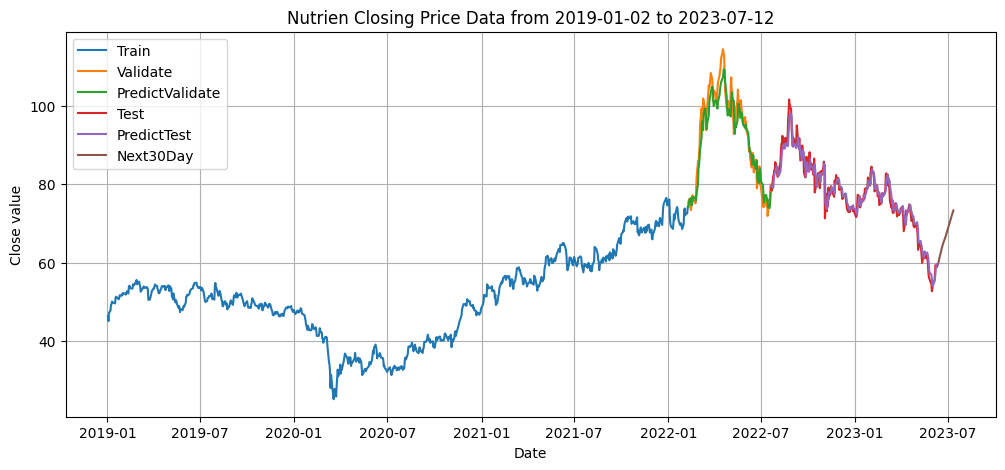

In [20]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size : train_size + val_size], y_pred_val)

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size : ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_NTR.png')
plt.show()